## Rotten Tomatoes review classification using bag-of-word models

In [1]:
import numpy as np
import pandas as pd
import timeit
import wordvecpy
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:/Users/steph/OneDrive/Documents/Data/rotten_tomatoes_reviews.csv')

Due to the size, we will only use the entire dataset to train the multinomial naive bayes and logistic regression model.  For the ensemble decision trees, only the first 10,000 rows of data will be used to train at first, then they will be compared and the best model developed will then be retrained on the full set of data.  Ths is because of the extremely long training time for both gradient boosted and random forest trees.

In [3]:
processor = wordvecpy.TextProcessor(df['Review'], lemmatizer='nltk')
df['Review'] = processor.transform(combined_strings=True)
df_small = df[:10000]

So first we transform our data into count matrix.  For multinomial naive-bayes and log reg, unigrams and bigrams will be used.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

x_train, x_test, y_train, y_test = train_test_split(df.Review, df.Freshness, test_size = 0.2, stratify=df.Freshness)

counts = CountVectorizer(ngram_range=(1,2))
x_train_counts = counts.fit_transform(x_train)
x_test_counts = counts.transform(x_test)

The first model built will be using multinomial naive bayes

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
rando_seed = 0

def fit_and_report(clf, x_tr, y_tr, x_te, y_te):
    t0=timeit.default_timer()
    clf.fit(x_tr, y_tr)
    t1=timeit.default_timer()
    print("\nModel: {}".format(clf))
    t1=timeit.default_timer()
    print("\nTraining accuracy: {}".format(accuracy_score(y_tr, clf.predict(x_tr))))
    print("\nTest score: {}".format(accuracy_score(y_te, clf.predict(x_te))))
    print('\nTime to train: {}\n'.format(round(t1-t0, 3)))
    
clf = MultinomialNB()
fit_and_report(clf, x_train_counts, y_train, x_test_counts, y_test)


Model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Training accuracy: 0.9775078125

Test score: 0.8771145833333334

Time to train: 0.513



Now we have to transform our count matrix into a tf-idf matrix which we will use for the rest of the models

In [6]:
tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
x_train_tfidf = tfidf.fit_transform(x_train_counts)
x_test_tfidf = tfidf.transform(x_test_counts)

Now we try logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression

def tfidf_and_counts(clf, x_train_counts, x_train_tfidf, y_train, x_test_counts, x_test_tfidf, y_test):
    print('\nTf-idf:\n')
    fit_and_report(clf, x_train_tfidf, y_train, x_test_tfidf, y_test)
    print('\nCount: \n')
    fit_and_report(clf, x_train_counts, y_train, x_test_counts, y_test)

clf = LogisticRegression(random_state=rando_seed)
tfidf_and_counts(clf, x_train_counts, x_train_tfidf, y_train, x_test_counts, x_test_tfidf, y_test)


Tf-idf:



C:\Users\steph\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Training accuracy: 0.9170859375

Test score: 0.8521875

Time to train: 20.951


Count: 


Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Training accuracy: 0.9959401041666667

Test score: 0.8939270833333334

Time to train: 99.686



We resplit the small dataframe into train and test and regenerate the count matrix and tf-idf matrix.  These models will be trained with only unigrams.

In [8]:
x_train_small, x_test_small, y_train_small, y_test_small = train_test_split(df_small.Review, df_small.Freshness, 
                                                                            test_size = 0.2, stratify=df_small.Freshness)

counts_small = CountVectorizer()
x_train_counts_small = counts_small.fit_transform(x_train_small)
x_test_counts_small = counts_small.transform(x_test_small)

tfidf_small = TfidfTransformer(norm='l2', sublinear_tf=True)
x_train_tfidf_small = tfidf.fit_transform(x_train_counts_small)
x_test_tfidf_small = tfidf.transform(x_test_counts_small)

Now for a gradient boosted tree ensemble.

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=200, random_state=rando_seed)
tfidf_and_counts(clf, x_train_counts_small, x_train_tfidf_small, y_train_small, x_test_counts_small, 
                 x_test_tfidf_small, y_test_small)


Tf-idf:


Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Training accuracy: 0.73025

Test score: 0.652

Time to train: 34.074


Count: 


Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Training accuracy: 0.708875

Test sc

Now for a random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=rando_seed)
tfidf_and_counts(clf, x_train_counts_small, x_train_tfidf_small, y_train_small, x_test_counts_small, 
                 x_test_tfidf_small, y_test_small)


Tf-idf:


Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Training accuracy: 1.0

Test score: 0.6765

Time to train: 8.23


Count: 


Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Training accuracy: 1.0

Test score: 0.6915

Time to train: 8.692



So random forest classifier outperforms the gradient boosted decision tree.  Now we run a quick check to estimate how many estimators optimizes test accuracy on the random forest.

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [16:54<00:00, 86.45s/it]


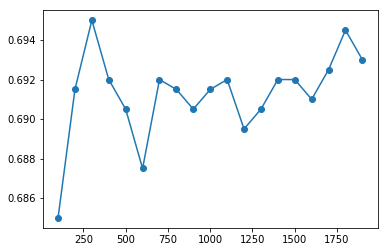

In [ ]:
import tqdm

acc_range = []
acc = []

for n in tqdm.tqdm(range(100, 2000, 100)):
    clf = RandomForestClassifier(n_estimators=n, n_jobs=-1, random_state=rando_seed)
    clf.fit(x_train_counts_small, y_train_small)
    acc_range.append(n)
    acc.append(accuracy_score(y_test_small, clf.predict(x_test_counts_small)))

plt.plot(acc_range, acc, marker='o', ls='-')

**Ouch**, that's a lot of non-uniform variation.  Really, though, the difference between the bottom and the top is only 0.6%.  1250 looks like the safest number of estimators to pick.  Let's see what the tf-idf random forests look like.

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [21:54<00:00, 123.98s/it]


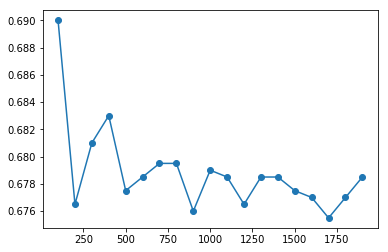

In [ ]:
acc_range = []
acc = []

for n in tqdm.tqdm(range(100, 2000, 100)):
    clf = RandomForestClassifier(n_estimators=n, n_jobs=2, random_state=rando_seed)
    clf.fit(x_train_tfidf_small, y_train_small)
    acc_range.append(n)
    acc.append(accuracy_score(y_test_small, clf.predict(x_test_tfidf_small)))

plt.plot(acc_range, acc, marker='o', ls='-')

While this plot is more uniform, it appears as though the peak accuracy with tf-idf is not much better than the mid-accuracy with straight word counts.

In [ ]:
#unigram_counts = CountVectorizer()
#x_train_counts = unigram_counts.fit_transform(x_train)
#x_test_counts = unigram_counts.transform(x_test)

#clf = RandomForestClassifier(n_estimators=1250, n_jobs=1, random_state=rando_seed)

#fit_and_report(clf, x_train_counts, y_train, x_test_counts, y_test)

The above model takes a long time to train, so I left it running (for a few days) on a separate computer.  The output from the model developed is shown below:


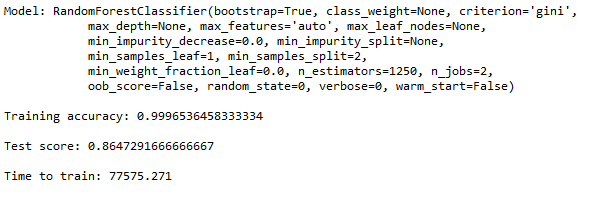

The "Time to train" listed above is in seconds, so it equates to over 21 hours training this model *on unigrams.*  This is compared to getting 89% accuracy on the test set with simple logistic regression in only *a minute and a half* with bigrams.  Clearly traditional methods such as logistic regression and multinomial naive-bayes are the best performers here.  It should be noted that all of these models are decently overfit.